# Machine Learning Engineer Nanodegree
## Capstone Project
Jonathan Sullivan  
November 24th, 2016

### Getting Started
We will first start this project by setting up our notebook to query the quandl API. We will start by setting the API key and writing a wrapper function to the quandl api calls. 

In [849]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import quandl as qd
import pandas as pd
qd.ApiConfig.api_key = 'zKcrvTFovarx8tGEkgJw'

def get_data(symbol, start_date=None, end_date=None):
    order = "asc"
    collapse="daily"
    returns = "pandas"
    if 'INDEX' in symbol:
        if (start_date == None) and (end_date == None):
            data = qd.get("YAHOO/"+symbol, collapse=collapse, order=order, returns=returns, transform="normalize")
        elif (start_date == None) :
            data = qd.get("YAHOO/"+symbol, end_date=end_date, collapse=collapse, transform="normalize", returns=returns)
        elif (end_date == None):
            data = qd.get("YAHOO/"+symbol, start_date=start_date, collapse=collapse, transform="normalize", returns=returns)
        else:
            data = qd.get("YAHOO/"+symbol, start_date=start_date, end_date=end_date, collapse=collapse, transform="normalize", returns=returns)
    else:
        if (start_date == None) and (end_date == None):
            data = qd.get("WIKI/"+symbol, collapse=collapse, order=order, returns=returns, transform="normalize")
        elif (start_date == None) :
            data = qd.get("WIKI/"+symbol, end_date=end_date, collapse=collapse, transform="normalize", returns=returns)
        elif (end_date == None):
            data = qd.get("WIKI/"+symbol, start_date=start_date, collapse=collapse, transform="normalize", returns=returns)
        else:
            data = qd.get("WIKI/"+symbol, start_date=start_date, end_date=end_date, collapse=collapse, transform="normalize", returns=returns)
    return data
    

### Data Exploration
#### Preparing the Data
Next we will load in stock data for the following companies in the technology sector:
* Apple (AAPL)
* Alphabet (GOOG)
* Microsoft (MSFT)
* Amazon (AMZN)
* Facebook (FB)
* Exxon Mobile (XOM)

We will also format the data where it has the follow features:
* Adj. Open
* Adj. Open n-day SMA
* Adj. Open n-day Bollinger
* Adj. Open n-day Momentum
* Adj. High
* Adj. High n-day SMA
* Adj. High n-day Bollinger
* Adj. High n-day Momentum
* Adj. Low
* Adj. Low n-day SMA
* Adj. Low n-day Bollinger
* Adj. Low n-day Momentum
* Adj. Volume  
* Adj. Volume n-day SMA
* Adj. Volume n-day Bollinger
* Adj. Volume n-day Momentum
* Adj. Close
* Adj. Close n-day SMA
* Adj. Close n-day Bollinger
* Adj. Close n-day Momentum


In [1015]:
import datetime
from sklearn import preprocessing
# Data filters
n = 20
look_back = 12
p = 30
p += 1
symbols = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'FB', 'XOM']#, 'INDEX_GSPC']


price_data = {}
clipped_price_data = {}
scaled_data = {}
end_date = datetime.date.today()
time_delta = datetime.timedelta(look_back*365/12 + n)
start_date = datetime.date.today() - time_delta

for symbol in symbols:
    price_data[symbol] = get_data(symbol, start_date=start_date, end_date=end_date)
    price_data[symbol].fillna(method='ffill', inplace=True)
    price_data[symbol].fillna(method='backfill', inplace=True)
    
    #Simple Moving Average
    price_data[symbol]['Adj. Open '+str(n)+'-day SMA'] = price_data[symbol]['Adj. Open'].rolling(window=n,center=False).mean()
    price_data[symbol]['Adj. High '+str(n)+'-day SMA'] = price_data[symbol]['Adj. High'].rolling(window=n,center=False).mean()
    price_data[symbol]['Adj. Low '+str(n)+'-day SMA'] = price_data[symbol]['Adj. Low'].rolling(window=n,center=False).mean()
    price_data[symbol]['Adj. Close '+str(n)+'-day SMA'] = price_data[symbol]['Adj. Close'].rolling(window=n,center=False).mean()
    
    #Bollinger
    price_data[symbol]['Adj. Open '+str(n)+'-day Bollinger'] = 2 * price_data[symbol]['Adj. Open'].rolling(window=n,center=False).std()
    price_data[symbol]['Adj. High '+str(n)+'-day Bollinger'] = 2 * price_data[symbol]['Adj. High'].rolling(window=n,center=False).std()
    price_data[symbol]['Adj. Low '+str(n)+'-day Bollinger'] = 2 * price_data[symbol]['Adj. Low'].rolling(window=n,center=False).std()
    price_data[symbol]['Adj. Close '+str(n)+'-day Bollinger'] = 2 * price_data[symbol]['Adj. Close'].rolling(window=n,center=False).std()
    
    #Momentum
    price_data[symbol]['Adj. Open '+str(n)+'-day Momentum'] = price_data[symbol]['Adj. Open'] - price_data[symbol]['Adj. Open'].shift(n)
    price_data[symbol]['Adj. High '+str(n)+'-day Momentum'] = price_data[symbol]['Adj. High'] - price_data[symbol]['Adj. High'].shift(n)
    price_data[symbol]['Adj. Low '+str(n)+'-day Momentum'] = price_data[symbol]['Adj. Low'] - price_data[symbol]['Adj. Low'].shift(n)
    price_data[symbol]['Adj. Close '+str(n)+'-day Momentum'] =  price_data[symbol]['Adj. Close'] - price_data[symbol]['Adj. Close'].shift(n) 
    
    
    price_data[symbol]['Adj. Close '+str(p)+'-day Rolling Standard Deviation'] = price_data[symbol]['Adj. Close'].rolling(window=p,center=False).std()
    price_data[symbol]['Difference between Adj. High and Adj. Low'] = (price_data[symbol]['Adj. High'] - price_data[symbol]['Adj. Low'])

    price_data[symbol] = price_data[symbol].drop('Open', 1)
    price_data[symbol] = price_data[symbol].drop('High', 1)
    price_data[symbol] = price_data[symbol].drop('Low', 1)
    price_data[symbol] = price_data[symbol].drop('Close', 1)
    price_data[symbol] = price_data[symbol].drop('Ex-Dividend', 1)
    price_data[symbol] = price_data[symbol].drop('Split Ratio', 1)
    clipped_price_data[symbol] = price_data[symbol][n:]

    scaled_data[symbol] = pd.DataFrame()
    scaled_data[symbol]['Adj. Open'] = preprocessing.scale(clipped_price_data[symbol]['Adj. Open'])
    scaled_data[symbol]['Adj. Close'] = preprocessing.scale(clipped_price_data[symbol]['Adj. Close'])
    scaled_data[symbol]['Adj. High'] = preprocessing.scale(clipped_price_data[symbol]['Adj. High'])
    scaled_data[symbol]['Adj. Low'] = preprocessing.scale(clipped_price_data[symbol]['Adj. Low'])

    scaled_data[symbol]['Adj. Open '+str(n)+'-day SMA'] = preprocessing.scale(clipped_price_data[symbol]['Adj. Open '+str(n)+'-day SMA'])
    scaled_data[symbol]['Adj. High '+str(n)+'-day SMA'] = preprocessing.scale(clipped_price_data[symbol]['Adj. High '+str(n)+'-day SMA'])
    scaled_data[symbol]['Adj. Low '+str(n)+'-day SMA'] = preprocessing.scale(clipped_price_data[symbol]['Adj. Low '+str(n)+'-day SMA'])
    scaled_data[symbol]['Adj. Close '+str(n)+'-day SMA'] = preprocessing.scale(clipped_price_data[symbol]['Adj. Close '+str(n)+'-day SMA'])

    scaled_data[symbol]['Adj. Open '+str(n)+'-day Bollinger'] = preprocessing.scale(clipped_price_data[symbol]['Adj. Open '+str(n)+'-day Bollinger'])
    scaled_data[symbol]['Adj. High '+str(n)+'-day Bollinger'] = preprocessing.scale(clipped_price_data[symbol]['Adj. High '+str(n)+'-day Bollinger'])
    scaled_data[symbol]['Adj. Low '+str(n)+'-day Bollinger'] = preprocessing.scale(clipped_price_data[symbol]['Adj. Low '+str(n)+'-day Bollinger'])
    scaled_data[symbol]['Adj. Close '+str(n)+'-day Bollinger'] = preprocessing.scale(clipped_price_data[symbol]['Adj. Close '+str(n)+'-day Bollinger'])

    scaled_data[symbol]['Adj. Open '+str(n)+'-day Momentum'] = preprocessing.scale(clipped_price_data[symbol]['Adj. Open '+str(n)+'-day Momentum'])
    scaled_data[symbol]['Adj. High '+str(n)+'-day Momentum'] = preprocessing.scale(clipped_price_data[symbol]['Adj. High '+str(n)+'-day Momentum'])
    scaled_data[symbol]['Adj. Low '+str(n)+'-day Momentum'] = preprocessing.scale(clipped_price_data[symbol]['Adj. Low '+str(n)+'-day Momentum'])
    scaled_data[symbol]['Adj. Close '+str(n)+'-day Momentum'] = preprocessing.scale(clipped_price_data[symbol]['Adj. Close '+str(n)+'-day Momentum'])
    
    scaled_data[symbol]['Volume'] = preprocessing.scale(clipped_price_data[symbol]['Volume'])

In [1016]:
price_data_features = {}
price_data_labels = {}
certainty = {}
for symbol in symbols:
    price_data_features[symbol] = clipped_price_data[symbol][['Adj. Open', 'Adj. Close', 'Adj. High', 'Adj. Low', 'Adj. Open '+str(n)+'-day SMA', 'Adj. Close '+str(n)+'-day SMA', 'Adj. High '+str(n)+'-day SMA', 'Adj. Low '+str(n)+'-day SMA', 'Adj. Open '+str(n)+'-day Bollinger', 'Adj. Close '+str(n)+'-day Bollinger', 'Adj. High '+str(n)+'-day Bollinger', 'Adj. Low '+str(n)+'-day Bollinger', 'Adj. Open '+str(n)+'-day Momentum', 'Adj. Close '+str(n)+'-day Momentum', 'Adj. High '+str(n)+'-day Momentum',  'Adj. Low '+str(n)+'-day Momentum', 'Adj. Volume']]
    price_data_labels[symbol] = clipped_price_data[symbol][['Adj. Close']]
    certainty[symbol] = {}
    certainty[symbol]['Adj. Close Standard Deviation Mean']  = clipped_price_data[symbol]['Adj. Close '+str(p)+'-day Rolling Standard Deviation'].mean()
    certainty[symbol]['Adj. Close Standard Deviation Standard Deviation']  = clipped_price_data[symbol]['Adj. Close '+str(p)+'-day Rolling Standard Deviation'].std()
    certainty[symbol]['Average Difference between Adj. High and Adj. Low'] = price_data[symbol]['Difference between Adj. High and Adj. Low'].mean()

In [1017]:
from IPython.display import display
clipped_price_data = {}
for symbol in symbols:
    if symbol == 'AAPL':
        display(symbol)
        display(price_data_features[symbol].iloc[[0, -1]])
        display(price_data_labels[symbol].iloc[[0, -1]])
        display(certainty[symbol])

'AAPL'

,Adj. Open,Adj. Close,Adj. High,Adj. Low,Adj. Open 20-day SMA,Adj. Close 20-day SMA,Adj. High 20-day SMA,Adj. Low 20-day SMA,Adj. Open 20-day Bollinger,Adj. Close 20-day Bollinger,Adj. High 20-day Bollinger,Adj. Low 20-day Bollinger,Adj. Open 20-day Momentum,Adj. Close 20-day Momentum,Adj. High 20-day Momentum,Adj. Low 20-day Momentum,Adj. Volume
Date,,,,,,,,,,,,,,,,,
2015-12-16,96.649843,97.932976,97.340287,96.011295,101.500609,102.461958,102.225120,101.842614,4.300926,4.671825,4.358913,5.062895,-3.350157,-2.067024,-2.659713,-3.988705,203.887398
2016-12-05,97.848806,98.098179,97.764898,97.651698,97.894394,98.908545,98.705806,98.123913,3.894579,3.006045,3.871551,3.621100,1.307616,0.233781,-0.195476,0.126293,121.617653


,Adj. Close
Date,
2015-12-16,97.932976
2016-12-05,98.098179


{'Adj. Close Standard Deviation Mean': 3.3770201530230066,
 'Adj. Close Standard Deviation Standard Deviation': 1.3450821646829092,
 'Average Difference between Adj. High and Adj. Low': 0.20802355607533948}

In [1018]:
import numpy as np

# TODO: Calculate number of dates
n_dates = len(price_data['AAPL'])
# TODO: Calculate number of features
n_features =  len(price_data['AAPL'].columns[:])
# Print the results
print "Total number of dates: {}".format(n_dates)
print "Number of features: {}".format(n_features)
for symbol in symbols:
    if symbol == 'AAPL':
        prices = price_data_features[symbol]
        print '\n'
        print "Statistics for "+symbol+" dataset:\n"
        for category in prices.columns.values:
            minimum_price = np.min(prices[category])
            maximum_price = np.max(prices[category])
            mean_price = np.mean(prices[category])
            median_price = np.median(prices[category])
            std_price = np.std(prices[category])

        # Show the calculated statistics
            print '----------------------------------------------'
            print "Minimum "+category+": {}".format(minimum_price)
            print "Maximum "+category+": {}".format(maximum_price)
            print "Mean "+category+": {}".format(mean_price)
            print "Median "+category+": {}".format(median_price)
            print "Standard deviation of  "+category+": {}".format(std_price)

Total number of dates: 265
Number of features: 20


Statistics for AAPL dataset:

----------------------------------------------
Minimum Adj. Open: 79.2182620968
Maximum Adj. Open: 104.582432648
Mean Adj. Open: 91.4531421875
Median Adj. Open: 92.0205360251
Standard deviation of  Adj. Open: 6.64611724418
----------------------------------------------
Minimum Adj. Close: 80.3778227857
Maximum Adj. Close: 105.776514966
Mean Adj. Close: 92.4603121426
Median Adj. Close: 93.2623801566
Standard deviation of  Adj. Close: 6.70813031838
----------------------------------------------
Minimum Adj. High: 80.5970278517
Maximum Adj. High: 105.126364563
Mean Adj. High: 92.1384956413
Median Adj. High: 93.0405305822
Standard deviation of  Adj. High: 6.59846476807
----------------------------------------------
Minimum Adj. Low: 79.8636748435
Maximum Adj. Low: 105.403935482
Mean Adj. Low: 91.939291069
Median Adj. Low: 92.8196009907
Standard deviation of  Adj. Low: 6.74865097803
---------------------------

3.37702015302


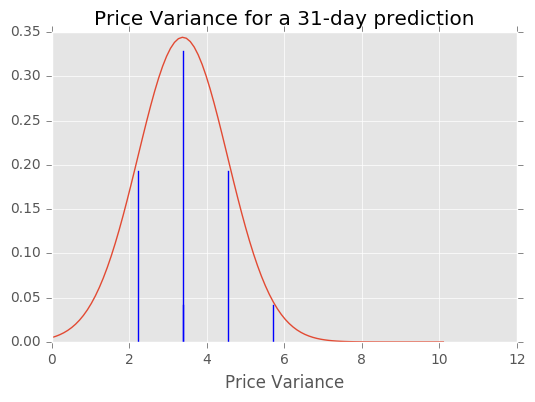

In [1019]:
import math
mu = certainty['AAPL']['Adj. Close Standard Deviation Mean']
variance = certainty['AAPL']['Adj. Close Standard Deviation Standard Deviation']
sigma = math.sqrt(variance)
x = np.linspace(0, mu+5*variance, 100)
plt.title('Price Variance for a '+ str(p) +'-day prediction')
plt.xlabel('Price Variance')
plt.axvline(x=mu, ymin=0, ymax=0.94)
plt.axvline(x=mu-variance**.5, ymin=0, ymax=0.55)
plt.axvline(x=mu+variance**.5, ymin=0, ymax=0.55)
plt.axvline(x=mu-0, ymin=0, ymax=0.12)
plt.axvline(x=mu+2*variance**.5, ymin=0, ymax=0.12)
plt.plot(x,matplotlib.mlab.normpdf(x, mu, sigma))
print mu

### Data Visualization

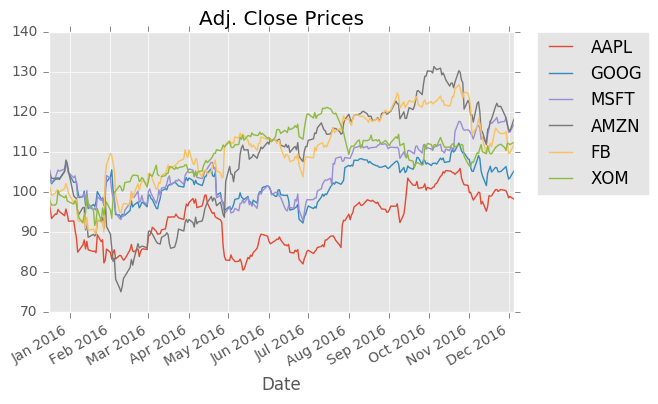

In [1020]:
matplotlib.style.use('ggplot')
closedf = pd.DataFrame()
for symbol in symbols:
    closedf[symbol] = price_data_features[symbol]['Adj. Close']
ax = closedf.plot(title = 'Adj. Close Prices')
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

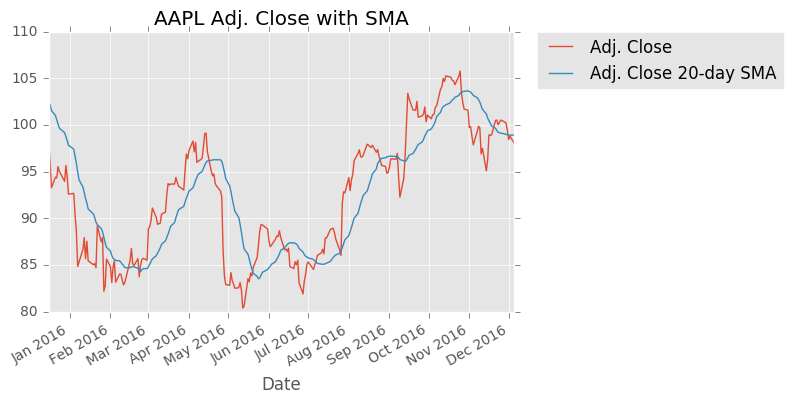

In [1021]:
for symbol in symbols:
    if symbol == 'AAPL':
        stock_close = pd.DataFrame()
        stock_close['Adj. Close'] = price_data_features[symbol]['Adj. Close']
        stock_close['Adj. Close '+str(n)+'-day SMA'] = price_data_features[symbol]['Adj. Close '+str(n)+'-day SMA']
        #stock_close['Adj. Close 20-day Bollinger Band Upper'] = stock_close['Adj. Close '+str(n)+'-day SMA'] + price_data_features[symbol]['Adj. Close 20-day Bollinger']
        #stock_close['Adj. Close 20-day Bollinger Band Lower'] = stock_close['Adj. Close '+str(n)+'-day SMA'] - price_data_features[symbol]['Adj. Close 20-day Bollinger']
        ax = stock_close.plot(title = symbol+" Adj. Close with SMA")
        legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

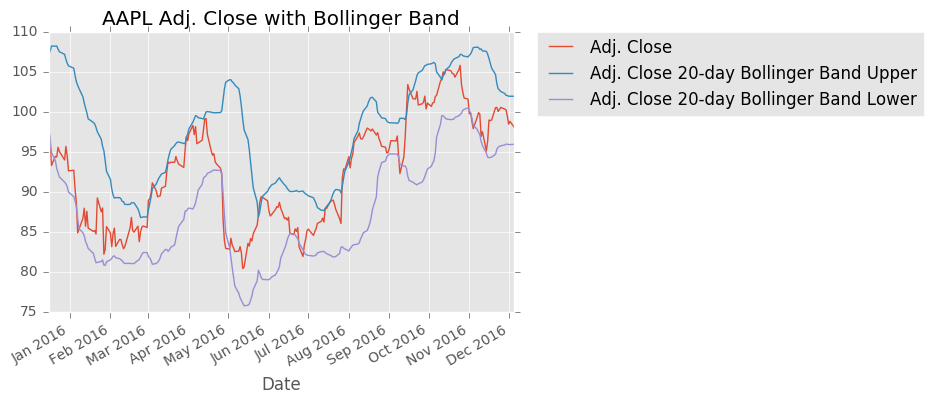

In [1022]:
for symbol in symbols:
    if symbol == 'AAPL':
        stock_close = pd.DataFrame()
        stock_close['Adj. Close'] = price_data_features[symbol]['Adj. Close']
        #stock_close['Adj. Close '+str(n)+'-day SMA'] = price_data_features[symbol]['Adj. Close '+str(n)+'-day SMA']
        stock_close['Adj. Close '+str(n)+'-day Bollinger Band Upper'] = price_data_features[symbol]['Adj. Close '+str(n)+'-day SMA'] + price_data_features[symbol]['Adj. Close '+str(n)+'-day Bollinger']
        stock_close['Adj. Close '+str(n)+'-day Bollinger Band Lower'] = price_data_features[symbol]['Adj. Close '+str(n)+'-day SMA'] - price_data_features[symbol]['Adj. Close '+str(n)+'-day Bollinger']
        ax = stock_close.plot(title = symbol+" Adj. Close with Bollinger Band")
        legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### Feature Reduction

In [1023]:
def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dim. {}'.format(i) for i in range(1,len(pca.components_)+1)]
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Ex. Var\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

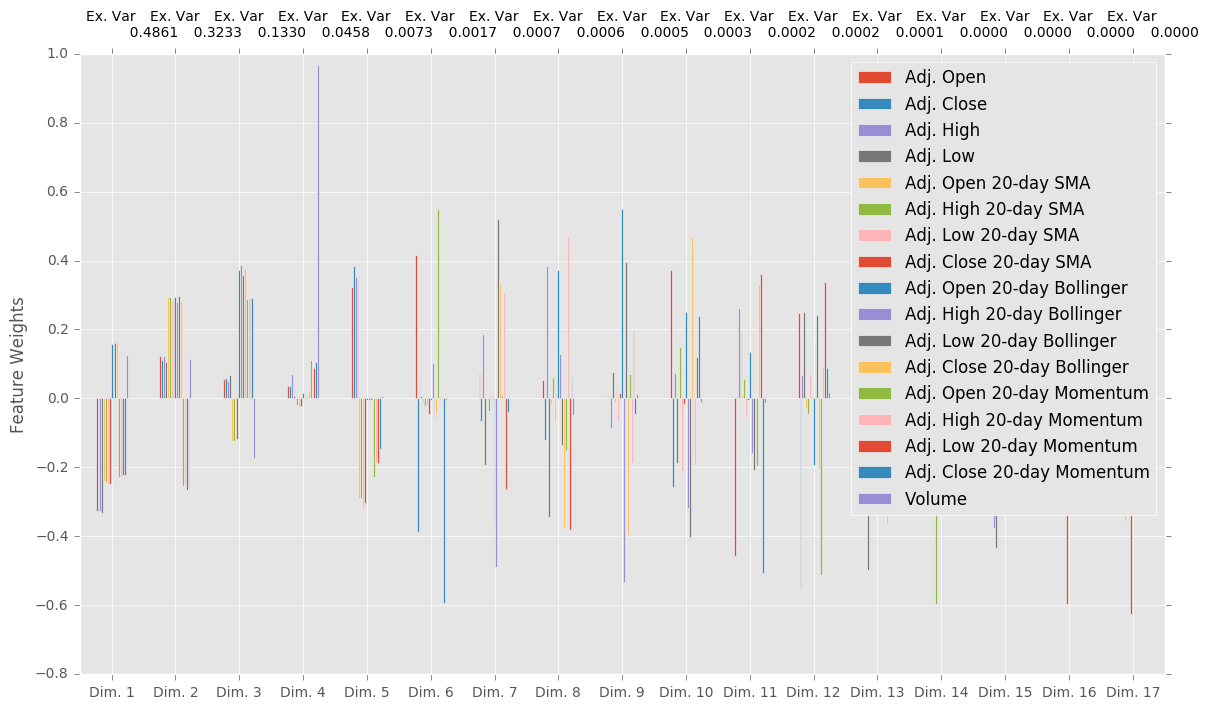

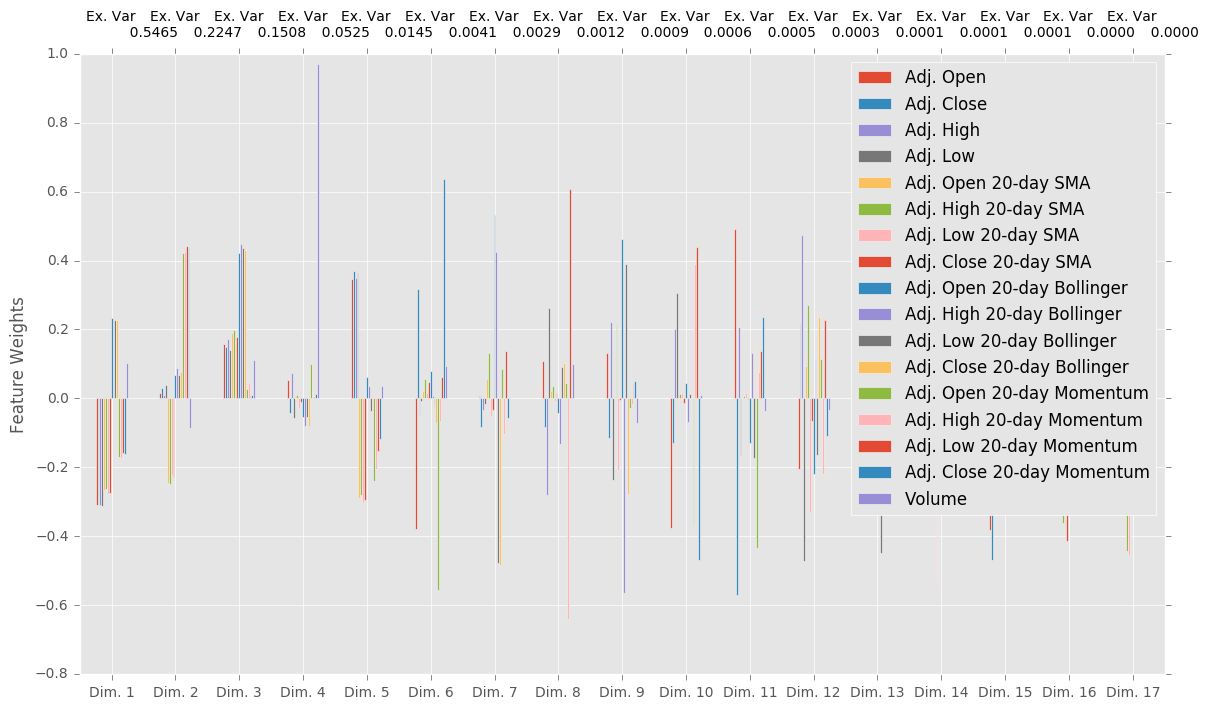

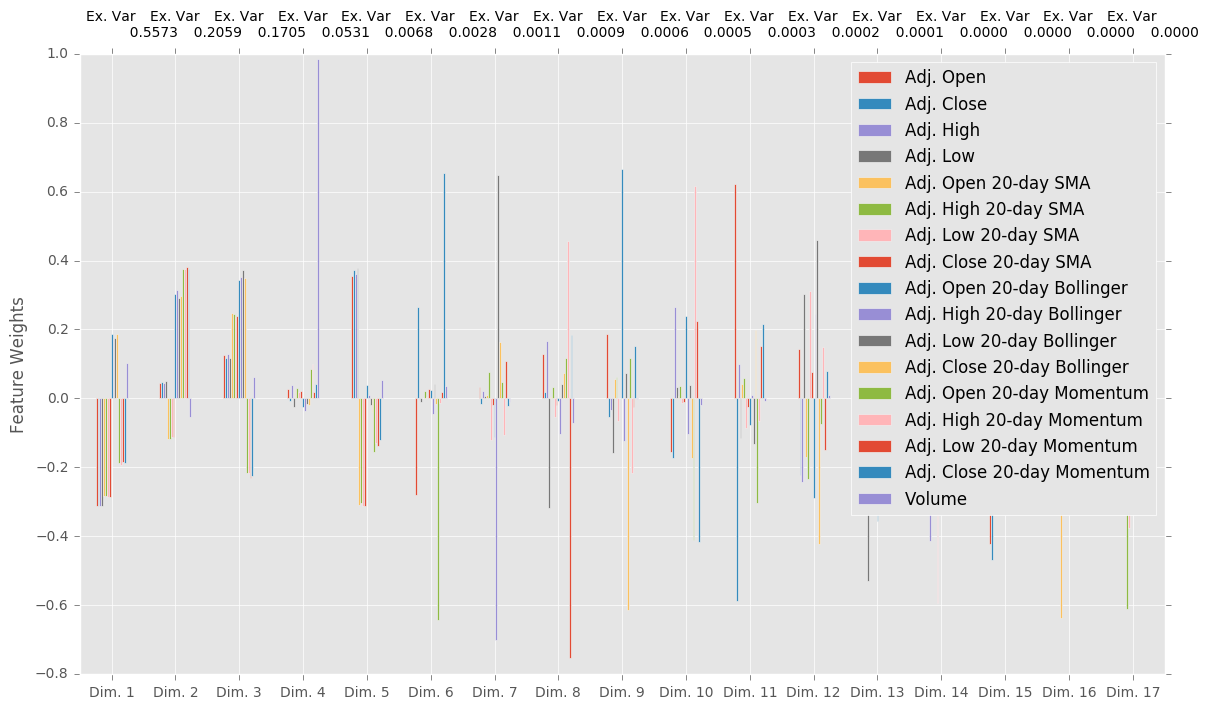

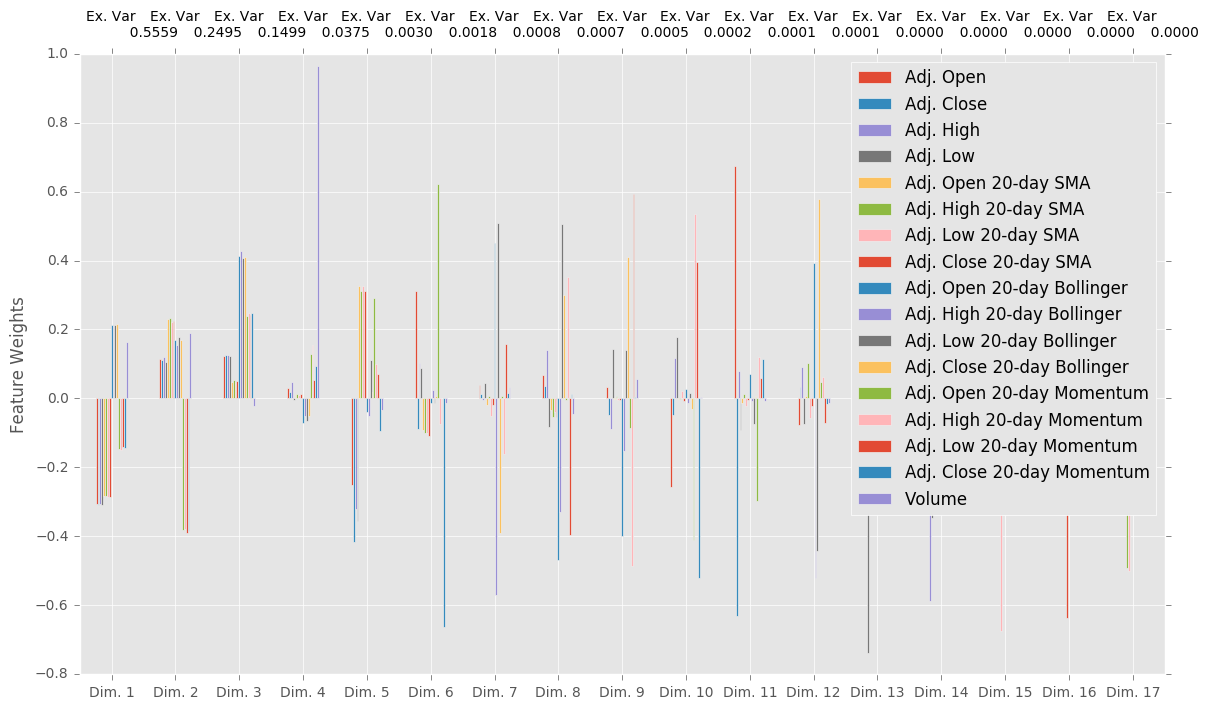

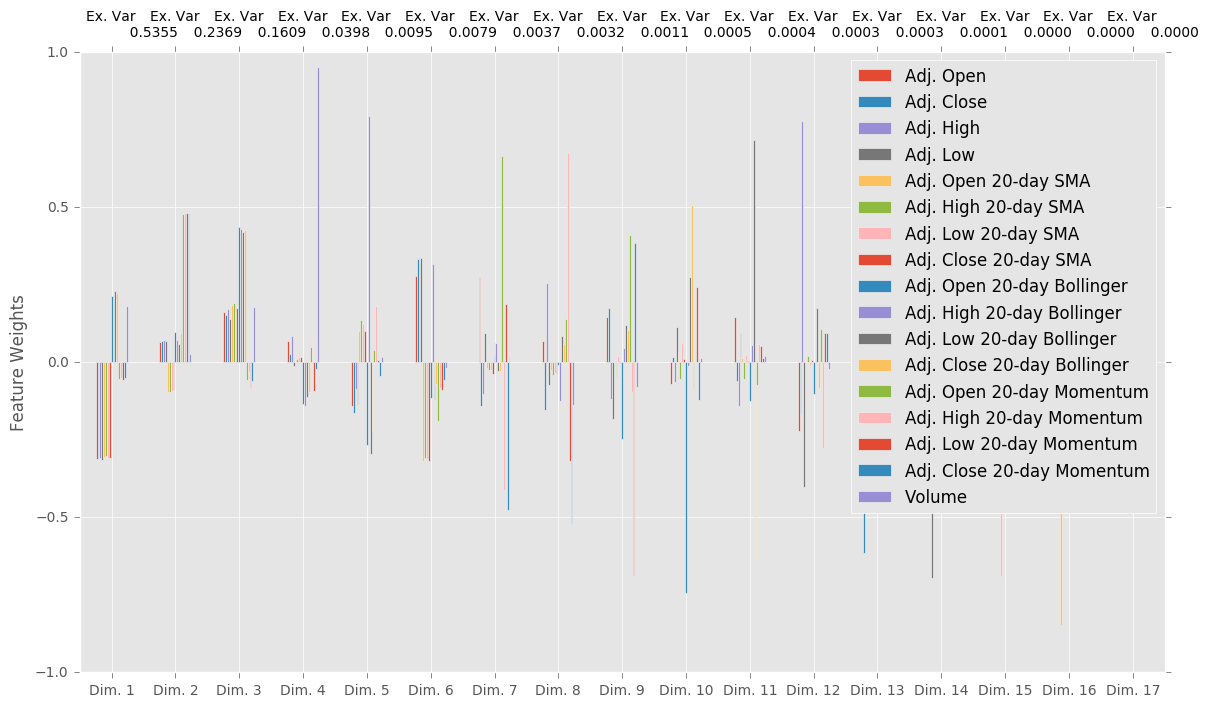

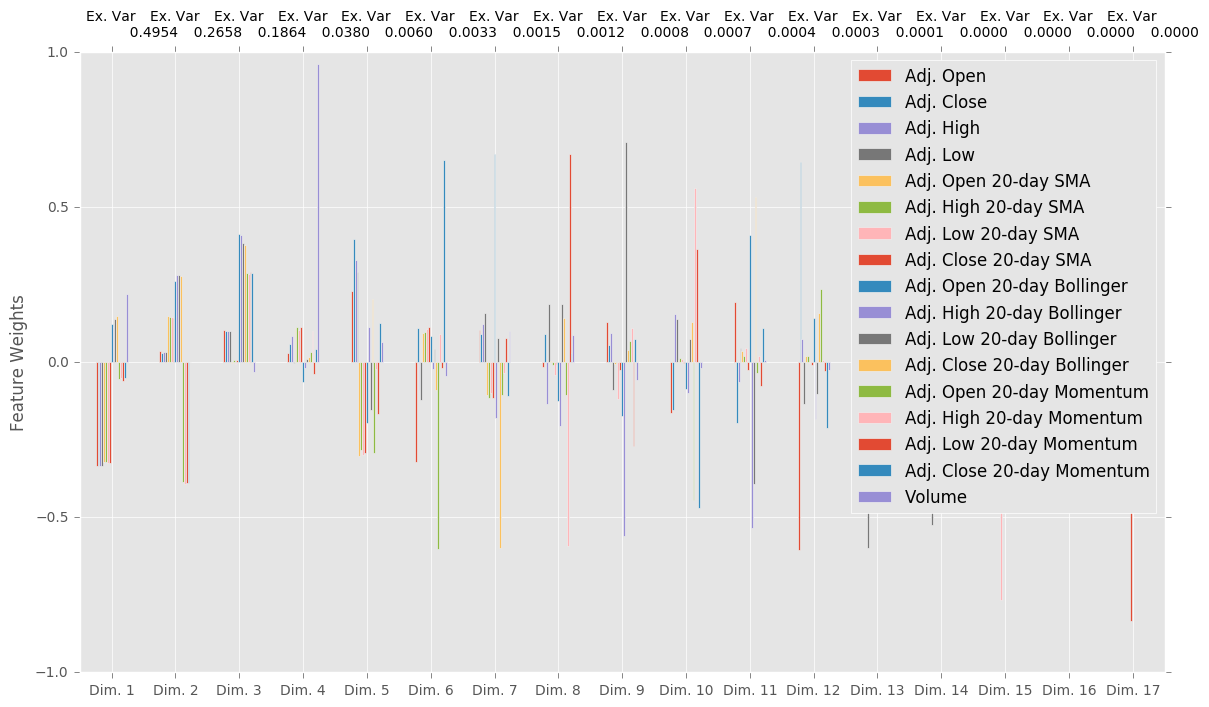

In [1024]:
from sklearn.decomposition import PCA
pca_result, pca_samples = {}, {}
for symbol in symbols:
    pca = PCA(n_components=17).fit(scaled_data[symbol])
    pca_samples[symbol] = pca.transform(scaled_data[symbol])
    pca_result[symbol] = pca_results(scaled_data[symbol], pca)

The first three principal components explain over 99% of variance in the data. This will reduce are feature space from a size of 17 to a size of 3.

'AAPL Principle Components'

,0,1,2
0,-2.232170,2.407369,-1.551390
1,-1.796495,2.877552,-1.403835
2,-0.046054,4.017133,-2.013975
3,0.207388,4.146603,-1.264659
4,0.151630,4.097018,-0.574147


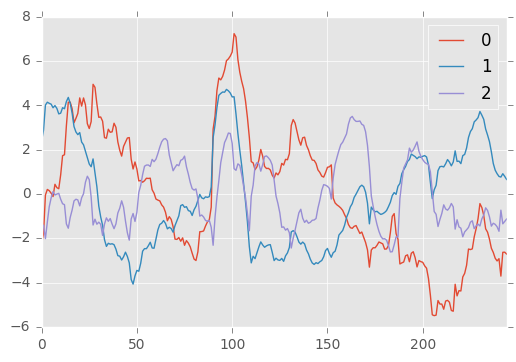

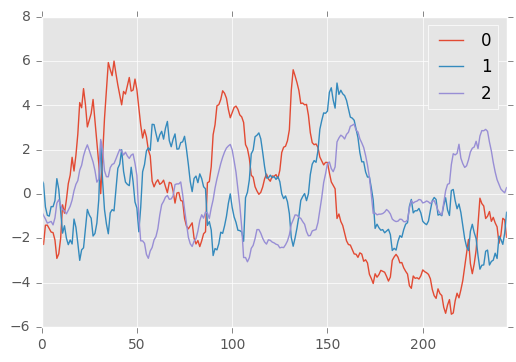

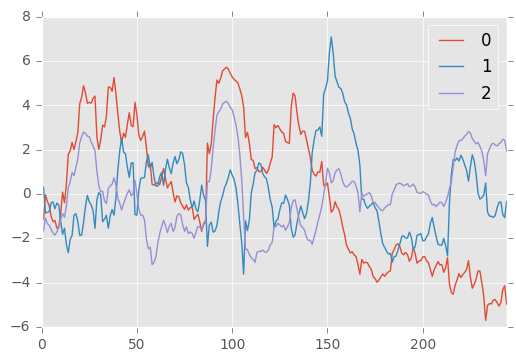

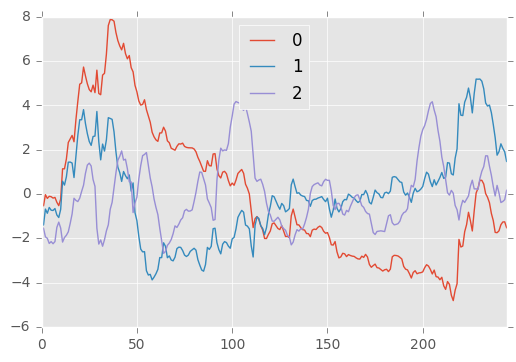

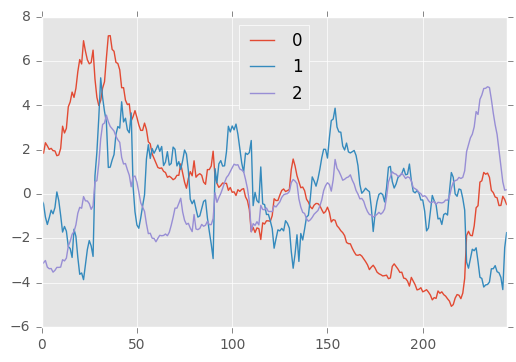

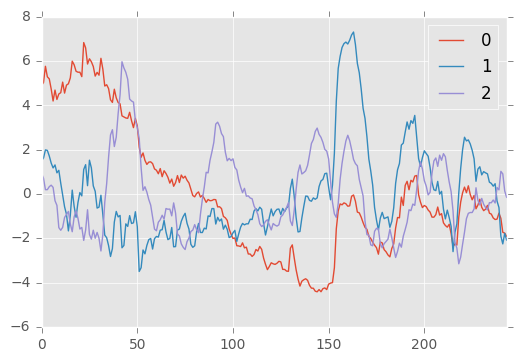

In [1025]:
reduced_price_data_features = {}
for symbol in symbols:
    reduced_price_data_features[symbol] = pd.DataFrame(pca_samples[symbol])[[0,1,2]]
    reduced_price_data_features[symbol].plot()
    if symbol == 'AAPL':
        display(symbol+" Principle Components")
        display(reduced_price_data_features[symbol].head())

### Implementation
we sill start by making a series of import that we need to implement our model.

In [1026]:
#import cross validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

#import metrics
from sklearn.metrics import mean_squared_error

#import Polynomial Regressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

#import KNN Regressor
from sklearn.neighbors import KNeighborsRegressor

#imprt timer for algorithms
import time

Next we will split the data in to test and train set.

Next we will set up a grid search to optimize our parameters and hyper-parameters for our supervised regression learners.

In [1027]:
def regression_bagging_train(X_train, y_train):
    print 'Training ensemble of learners'
    en_start = time.time()
    parameters1 = {'metric':('euclidean', 'manhattan'), 'n_neighbors': range(len(X_train)/2)[(1*len(X_train)/4):(3*len(X_train)/4)], 'weights':('uniform', 'distance'), 'algorithm':('auto', 'ball_tree', 'kd_tree')}
    regressor1 = KNeighborsRegressor()
    
    print 'Training KNN'
    start = time.time()
    reg1 = GridSearchCV(regressor1, parameters1)
    reg1.fit(X_train,y_train)
    end = time.time()
    print 'Trained KNN in ' + str(end - start) + ' seconds' 
    print 'Training Polynomial Regressor'
    start = time.time()
    mse_min = 999999999999999
    final_degree = 0
    for degree in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]:
        regressor2 = Pipeline([('poly', PolynomialFeatures(degree = degree)), ('linear', LinearRegression(fit_intercept = True))])
        reg2 = regressor2
        reg2.fit(X_train[:3*len(X_train)/4],y_train[:3*len(X_train)/4])
        temp_pred = reg2.predict(X_train[3*len(X_train)/4:])
        instant_err = mean_squared_error(temp_pred, y_train[3*len(X_train)/4:])
        if instant_err < mse_min:
            final_degree = degree
            mse_min = instant_err
            reg2_final = reg2
    end = time.time()
    print 'Trained Polynomial Regressor in ' + str(end - start) + ' seconds'  
    en_end = time.time()
    print 'Trained ensemble of learners in ' + str(en_end - en_start) + ' seconds' 
    return (reg1, reg2_final)

def train_model(X_train, y_train):
    print 'Training model'
    start = time.time()
    reg1, reg2 = regression_bagging_train(X_train, y_train)
    #reg = regression_ANN_train(X_train, y_train, reg1, reg2)
    end = time.time()
    return (reg1, reg2)
    #return [(reg1, reg2), reg]

def predict(model, X_test):
    print 'Making predictions'
    #pred_1 = model[0][0].predict(X_test)
    #pred_2 = model[0][1].predict(X_test)
    #ANN_test = pd.DataFrame({'r1': pred_1, 'r2': pred_2})
    pred_1 = model[0].predict(X_test)
    pred_2 = model[1].predict(X_test)
    pred = pd.DataFrame({'r1': pred_1, 'r2': pred_2}).mean(axis=1)
    return pred

def score(y_pred, y_true):
    return mean_squared_error(y_pred, y_true)

In [1028]:
model_data, X_train, X_test, y_train, y_test, predictions, models, true_labels, scores, acc=  {}, {}, {}, {}, {}, {}, {}, {}, {}, {}
for symbol in symbols:
    print symbol
    models[symbol] = []
    predictions[symbol] = []
    true_labels[symbol] = []
    scores[symbol] = []
    acc[symbol] = []
    tscv = TimeSeriesSplit(n_splits= 5)
    features, labels = reduced_price_data_features[symbol], price_data_features[symbol]['Adj. Close']
    y_train[symbol], y_test[symbol], X_train[symbol], X_test[symbol] =[], [], [], []
    for i, index in enumerate(tscv.split(features)):
        print(symbol + ' test: ' + str(i))
        start = time.time()
        train_index, test_index = index[0], index[1]
        X_train[symbol].append(features[train_index[0]:train_index[-1]])
        X_test[symbol].append(features[test_index[0]:test_index[-1]])
        y_train[symbol].append(labels[train_index]) 
        y_test[symbol].append(labels[test_index])
        end = time.time()
        print('Finished spliting data for '+ symbol + ' test ' + str(i) +' in ' + str(end - start) + ' seconds')
        start = time.time()
        models[symbol].append(train_model(X_train[symbol][i], y_train[symbol][i][0:-1]))
        end = time.time()
        print('Finished fitting data for '+ symbol + ' test' + str(i) +' in ' + str(end - start) + ' seconds')       
        true_labels[symbol].append(y_test[symbol][i])
        start = time.time()
        predictions[symbol].append(predict(models[symbol][i], X_test[symbol][i]))
        end = time.time()
        print('Finished predictions on data for '+ symbol + ' test' + str(i) +' in ' + str(end - start) + ' seconds')
        start = time.time()
        scores[symbol].append(score(predictions[symbol][i], true_labels[symbol][i][0:-1]))
        end = time.time()
        start = time.time()
    print('TEST ' + str(i)+' DONE')

AAPL
AAPL test: 0
Finished spliting data for AAPL test 0 in 0.000752925872803 seconds
Training model
Training ensemble of learners
Training KNN
Trained KNN in 3.53558421135 seconds
Training Polynomial Regressor
Trained Polynomial Regressor in 0.562630176544 seconds
Trained ensemble of learners in 4.09867405891 seconds
Finished fitting data for AAPL test0 in 4.09888911247 seconds
Making predictions
Finished predictions on data for AAPL test0 in 0.00285792350769 seconds
AAPL test: 1
Finished spliting data for AAPL test 1 in 0.000568151473999 seconds
Training model
Training ensemble of learners
Training KNN
Trained KNN in 8.41526699066 seconds
Training Polynomial Regressor
Trained Polynomial Regressor in 0.406933069229 seconds
Trained ensemble of learners in 8.82251596451 seconds
Finished fitting data for AAPL test1 in 8.82267904282 seconds
Making predictions
Finished predictions on data for AAPL test1 in 0.00269603729248 seconds
AAPL test: 2
Finished spliting data for AAPL test 2 in 0.00

In [1029]:
print "Algorithm"
mean_sq_err = {}
for symbol in symbols:
    acc[symbol], mean_sq_err[symbol] = [], []
    for i, data in enumerate(true_labels[symbol]):
        abs_err = pd.Series(true_labels[symbol][i][0:-1].values) - pd.Series(predictions[symbol][i].values)
        abs_err = abs_err.abs()
        acc_bool = abs_err[abs_err < certainty[symbol]['Adj. Close Standard Deviation Mean']]
        acc[symbol].append(100*(float(len(acc_bool))/float(len(abs_err))))
        mean_sq_err[symbol].append(mean_squared_error(true_labels[symbol][i][0:-1], pd.Series(predictions[symbol][i].values)))
    print('Percent within one mean standard deviation of prediction for '+ symbol +' is ' + str(np.mean(acc[symbol])) + '%')
    print(np.mean(mean_sq_err[symbol]))
print "Naive"
for symbol in symbols:
    acc[symbol] = []
    for i, data in enumerate(true_labels[symbol]):
        our_lab = true_labels[symbol][i][0:-p].values
        naive_lab = true_labels[symbol][i][p:].values
        abs_err = np.absolute(np.subtract(np.array(our_lab), np.array(naive_lab)))
        acc_bool = abs_err[abs_err < certainty[symbol]['Adj. Close Standard Deviation Mean']]
        acc[symbol].append(100*(float(len(acc_bool))/float(len(abs_err))))
        mean_sq_err[symbol].append(mean_squared_error(pd.Series(our_lab), pd.Series(naive_lab).values))
    print('Percent within one mean standard deviation of prediction for '+ symbol +' is ' + str(np.mean(acc[symbol])) + '%')
    print(np.mean(mean_sq_err[symbol]))

Algorithm
Percent within one mean standard deviation of prediction for AAPL is 76.9230769231%
6.4656237302
Percent within one mean standard deviation of prediction for GOOG is 81.0256410256%
3.04565467739
Percent within one mean standard deviation of prediction for MSFT is 62.0512820513%
6.42042539484
Percent within one mean standard deviation of prediction for AMZN is 54.358974359%
23.6071568026
Percent within one mean standard deviation of prediction for FB is 56.4102564103%
12.395139606
Percent within one mean standard deviation of prediction for XOM is 57.4358974359%
8.18598155267
Naive
Percent within one mean standard deviation of prediction for AAPL is 15.5555555556%
32.8112963151
Percent within one mean standard deviation of prediction for GOOG is 31.1111111111%
23.0677916538
Percent within one mean standard deviation of prediction for MSFT is 35.5555555556%
32.9287336534
Percent within one mean standard deviation of prediction for AMZN is 0.0%
68.4343160851
Percent within one m

In [1030]:
for symbol in symbols:
    print "The parameter for our kNN Regressor for the equity " +symbol+ " are " + str(models[symbol][-1][0].best_estimator_.get_params())
    print "The power for our Polynomial Regressor for the equity " +symbol+ " is" + str(models[symbol][-1][1].named_steps['poly'].powers_)
    print "The coefficients for our Polynomial Regressor for the equity " +symbol+ " is" + str(models[symbol][-1][1].named_steps['linear'].coef_)
    print "The intercept for our Polynomial Regressor for the equity " +symbol+ " is" +str( models[symbol][-1][1].named_steps['linear'].coef_)

The parameter for our kNN Regressor for the equity AAPL are {'n_neighbors': 51, 'n_jobs': 1, 'algorithm': 'auto', 'metric': 'euclidean', 'metric_params': None, 'p': 2, 'weights': 'distance', 'leaf_size': 30}
The power for our Polynomial Regressor for the equity AAPL is[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]]
The coefficients for our Polynomial Regressor for the equity AAPL is[ 0.         -2.09896706  0.6642582   0.45114073]
The intercept for our Polynomial Regressor for the equity AAPL is[ 0.         -2.09896706  0.6642582   0.45114073]
The parameter for our kNN Regressor for the equity GOOG are {'n_neighbors': 51, 'n_jobs': 1, 'algorithm': 'auto', 'metric': 'euclidean', 'metric_params': None, 'p': 2, 'weights': 'distance', 'leaf_size': 30}
The power for our Polynomial Regressor for the equity GOOG is[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]]
The coefficients for our Polynomial Regressor for the equity GOOG is[ 0.         -1.35860002  0.19866336  0.67538654]
The intercept for our Polynomial Regr

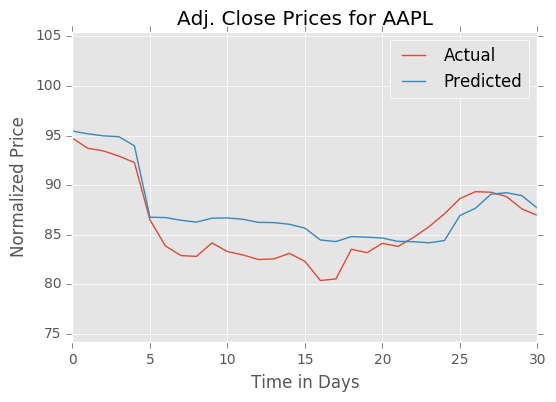

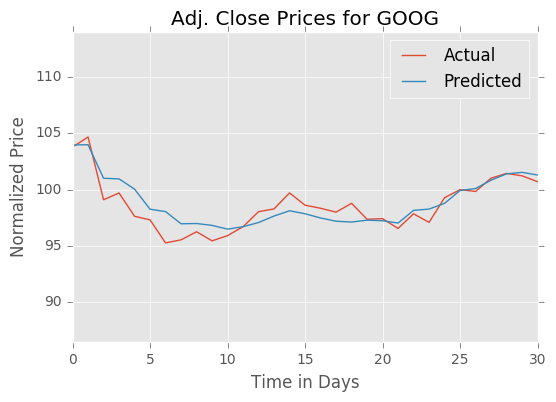

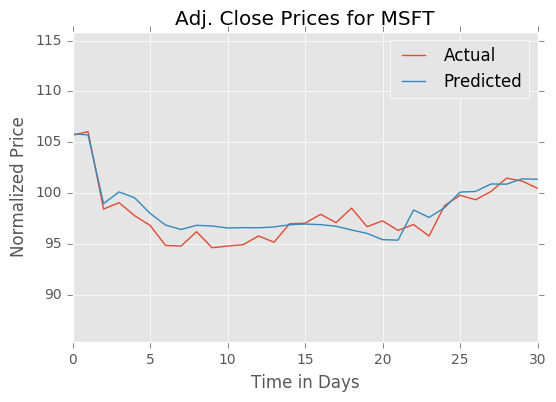

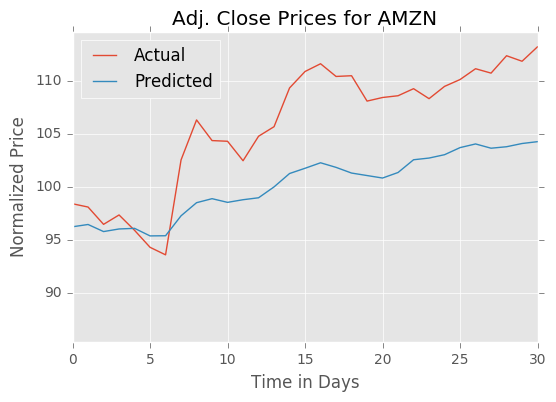

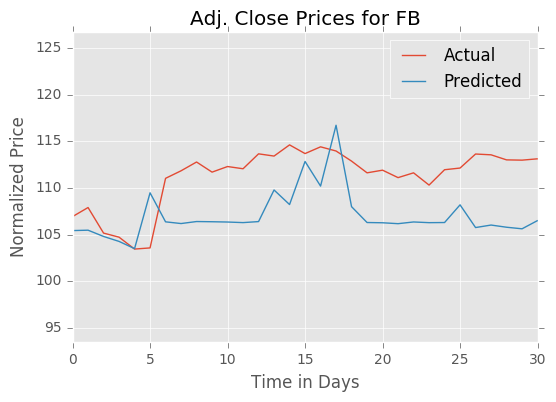

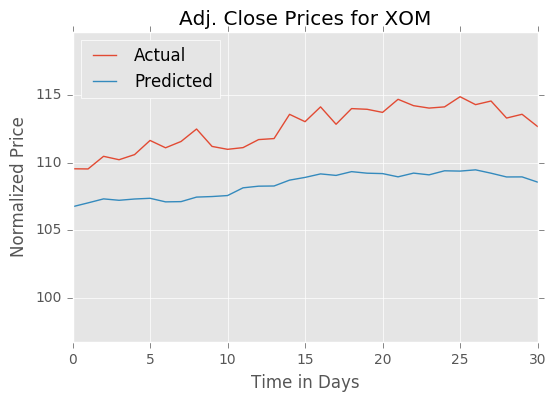

In [1031]:
closingdf = {}
for symbol in symbols:
    closingdf[symbol] = pd.DataFrame()
    closingdf[symbol]['Actual'] = pd.Series(np.array(true_labels[symbol][:-1][1]))
    closingdf[symbol]['Predicted'] = pd.Series(np.array(predictions[symbol][:-1])[1])
    ax = closingdf[symbol].plot(title = 'Adj. Close Prices for ' + symbol)
    maximum_y =  closingdf[symbol]['Predicted'].max().max() + 10
    minimum_y =  closingdf[symbol]['Predicted'].min().min() - 10
    plt.xlim(0,p-1)
    plt.xlabel('Time in Days')
    plt.ylim(minimum_y,maximum_y)
    plt.ylabel('Normalized Price')